# Notebook Title: Exploratory Data Analysis for Release QC Metrics

## Description:
This notebook provides an exploratory data analysis for release quality control (QC) metrics. It analyzes various metrics related to genetic variant data, variant-to-gene assignments, study indices, credible sets, colocalization, and locus-to-gene predictions. The notebook utilizes PySpark and pandas for data processing and visualization.

## Notebook Workflow:
1. Import necessary modules and set up the release path and version.
2. Load and analyze the variant index data:
   - Count the number of unique variants.
3. Load and analyze the variant-to-gene (v2g) data:
   - Count the number of unique variants and total variant-to-gene assignments.
   - Count the number of v2g assignments where the score is > 0.8.
   - Plot a histogram/density plot for the "score" column.
4. Load and analyze the study index data for different data sources (FinnGen, GWASCat, eQTLcat):
   - Count the number of unique studies for each data source.
   - Plot a histogram/density plot for the total sample size.
5. Analyze the credible sets:
   - Analyze the FinnGen susie credible sets:
     - Count the number of unique FinnGen susie credible sets and unique study IDs.
     - Plot a scatter plot of the credible set size vs. the top posterior probability.
     - Count the number of credible sets with a top SNP posterior probability > 0.9.
   - Analyze the eQTL catalog susie credible sets:
     - Count the number of unique eQTL catalog susie credible sets and unique study IDs.
     - Plot a scatter plot of the credible set size vs. the top posterior probability.
     - Count the number of credible sets with a top SNP posterior probability > 0.9.
   - Analyze the GWAS catalog sumstats (PICs) credible sets:
     - Count the number of unique GWAS catalog sumstats credible sets and unique study locus IDs.
     - Plot a scatter plot of the credible set size vs. the top posterior probability.
     - Count the number of credible sets with a top SNP posterior probability > 0.9.
   - Analyze the GWAS catalog curated (PICs) credible sets:
     - Count the number of unique GWAS catalog curated credible sets and unique study locus IDs.
     - Plot a scatter plot of the credible set size vs. the top posterior probability.
     - Count the number of credible sets with a top SNP posterior probability > 0.9.
6. Analyze colocalization data:
   - Count the total number of colocalizations and the number with clpp > 0.8.
   - Calculate the average number of overlaps per credible set.
7. Analyze locus-to-gene (L2G) predictions:
   - Load the locus-to-gene predictions data.
   
Note: This notebook assumes that the necessary data files are available in the specified release path and version.


### Setup steps
##### 1. Import necessary modules and set up the release path and version.

In [1]:
"""notebook for release qc metrics."""

import sys
import matplotlib.pyplot as plt
from gentropy.common.session import Session
from pyspark.sql import functions as f

sys.path.append("../../gentropy/src/")
release_path="../../otg_releases"
release_ver="2403"

session=Session()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/03/18 14:08:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### 2. Load and analyze the variant index data:
   - Count the number of unique variants.

In [2]:

variant_index_path = f"{release_path}/{release_ver}/variant_index"
variant_index=session.spark.read.parquet(variant_index_path, recursiveFileLookup=True)

# How many variants?
print("Variant index contains ", variant_index.select(f.col("variantId")).distinct().count(), " unique variants.")

# How many variants with MAF>=0.01 for EUR population?
#variant_index.filter(variant_index["alleleFrequencies.populationName"] > 0.05).show(10, False)

Variant index contains  5468737  unique variants.


In [3]:
variant_index.select("chromosomeB37").distinct().show(30, False)

+-------------+
|chromosomeB37|
+-------------+
|15           |
|22           |
|16           |
|null         |
|9            |
|1            |
|21           |
|2            |
|7            |
|11           |
|3            |
|6            |
|GL000192.1   |
|X            |
|4            |
|8            |
|5            |
|18           |
|Y            |
|17           |
|19           |
|20           |
|10           |
|12           |
|13           |
|GL000202.1   |
|GL000196.1   |
|GL000199.1   |
|GL000211.1   |
|14           |
+-------------+
only showing top 30 rows



#####   The number of variants appears low, because only variants that appears at least in one GWAS ingested, and MAF >= 0.01.

#### 3. Load and analyze the variant-to-gene (v2g) data:
   - Count the number of unique variants and total variant-to-gene assignments.
   - Count the number of v2g assignments where the score is > 0.8.

In [4]:
#v2g_path='gs://genetics_etl_python_playground/releases/24.03/variant_to_gene'
v2g_path=f"{release_path}/{release_ver}/variant_to_gene"
v2g=session.spark.read.parquet(v2g_path, recursiveFileLookup=True)

#How many variants?
print("Unique variants in v2g release: ", v2g.select(f.col("variantId")).distinct().count(), ", total variant to gene assignments: ", v2g.count(), ", number of v2g assignments where score > 0.8: ", v2g.filter(v2g["score"] > 0.8).count(), "(", round( v2g.filter(v2g["score"] > 0.8).count()/v2g.select(f.col("variantId")).distinct().count(), 3), "%)")
#v2g.select().toPandas().plot.hist()
#v2g.show()

Unique variants in v2g release:  5090991 , total variant to gene assignments:  105771851 , number of v2g assignments where score > 0.8:  23176515 ( 4.552 %)


   - Plot a histogram/density plot for the "score" column.

In [ ]:
#The histogram/density plot for “score”

#v2g.select(f.col("score")).toPandas().plot.hist(bins=10, alpha=0.5, label="v2g scores")

##### 5. Analyze the credible sets:
For each datasource and finemapping methods:
- Count the number of unique credible sets and unique study IDs.
- Plot a scatter plot of the credible set size vs. the top posterior probability.
- Count the number of credible sets with a top SNP posterior probability > 0.9.


In [6]:
# study_index='gs://genetics_etl_python_playground/releases/24.03/study_index'
# Study Index. It has different files for different datasource (FinnGen, GWASCat, eQTLcat).

eqtl_index_path=f"{release_path}/{release_ver}/study_index/eqtl_catalogue"
gwascat_path=f"{release_path}/{release_ver}/study_index/gwas_catalog"

# Credible_set. Please use Daniels’ notebook as a reference. For each subfolder:
finngen_index_path=f"{release_path}/{release_ver}/study_index/finngen"
# finngen susie:
finngen_susie_path=f"{release_path}/{release_ver}/credible_set/finngen_susie"

finngen_susie=session.spark.read.parquet(finngen_susie_path, recursiveFileLookup=True)
print("Number of unique finngen susie CSs: ", finngen_susie.select("studyId", "region", "credibleSetIndex").distinct().count())


# FinnGen:
finngen_index=session.spark.read.parquet(finngen_index_path, recursiveFileLookup=True)
# Number of CSs, studies.
print("Ingested ", finngen_susie.select("studyId", "region", "credibleSetIndex").distinct().count(), " Credible sets from", finngen_index.select(f.col("studyId")).distinct().count(), "finngen studies")
sample_size_quartiles = finngen_index.stat.approxQuantile("nSamples", [0.25, 0.5, 0.75], 0.01)
print("Summary of finngen sample sizes: Mean: ", finngen_index.select(f.mean(finngen_index["nSamples"])).collect()[0][0], "L.quart: ", sample_size_quartiles[0], "Median: ", sample_size_quartiles[1], "U.quart: ", sample_size_quartiles[2])
# Number of unique studyids with at leas one CS.
print("Number of finngen studies with at least one CS: ", finngen_susie.select("studyId").distinct().count())
# Number of CSs with at leas one SNP with PIP>0.9
print("Number of CS with top SNP PP > 0.9: ", finngen_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).filter(f.col("top_PP") > 0.9).count())
# The descriptive summary of 99% CS size and histogram/density plot

credset_size_quartiles = finngen_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("credset_size", f.size(f.col("posteriorProbability"))).stat.approxQuantile("credset_size", [0.25, 0.5, 0.75], 0.01)
print("Summary of finngen credible set sizes: L.quart: ", credset_size_quartiles[0], "Median: ", credset_size_quartiles[1], "U.quart: ", credset_size_quartiles[2])

finngen_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability"))).toPandas().plot.scatter(x="credset_size", y="top_PP", xlim=[0, 500], alpha=0.05, label="finngen susie CSs", title="finngen susie credsets")



# The histogram/density plot for total sample size
finngen_index.select(f.col("nSamples")).toPandas().plot.hist(bins=10, alpha=0.5, label="FinnGen sample size", title="FinnGen sample sizes")
# eQTLcat:
# Number of studies
eqtl_index=session.spark.read.parquet(eqtl_index_path, recursiveFileLookup=True)
print("Number of unique eQTLcat studies: ", eqtl_index.select(f.col("studyId")).distinct().count())
# Number of tissues, list of tissues
print("Number of unqiue eQTLcat tissues: ", eqtl_index.select(f.col("tissueFromSourceId")).distinct().count())
#eqtl_index.select(f.col("tissueFromSourceId")).distinct().show(truncate=False)

# Gwas Catalog:
gwascat_index=session.spark.read.parquet(gwascat_path, recursiveFileLookup=True)
# Number of GWAS curated studies
print("Number of unique gwascat studies: ", gwascat_index.select(f.col("studyId")).distinct().count())
# Number of studies with full GWAS sumstats
print("Number of unique SUMSTATS gwascat studies: ", gwascat_index.filter(f.col("hasSumstats") == True).select(f.col("studyId")).distinct().count())
#gwascat_index
# The histogram/density plot for total sample size separately for curated studies and full GWAS
gwascat_index.filter(f.col("hasSumstats") == True).select(f.col("nSamples")).toPandas().plot.hist(bins=25, alpha=0.5, label="Sumstats GWAScat sample size", title="Sumstats GWAScat sample size")
gwascat_index.filter(f.col("hasSumstats") == False).select(f.col("nSamples")).toPandas().plot.hist(bins=25, alpha=0.5, label="Sumstats GWAScat sample size", title="Curated GWAScat sample size")
     

Number of unique finngen susie CSs:  13966
Number of finngen studies with at least one CS:  1194


Number of CS with top SNP PP > 0.9:  1898


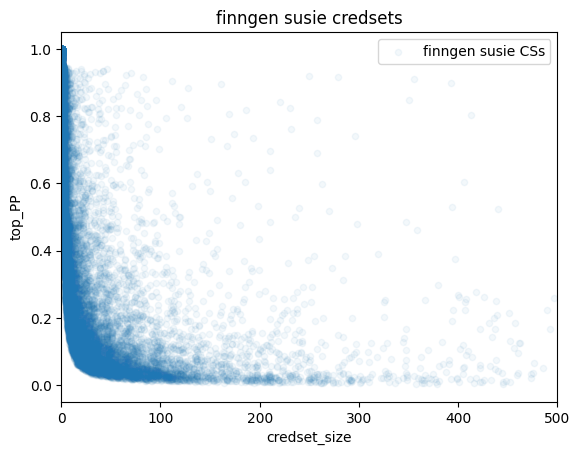

Number of unique eqtl catalog susie CSs:  2055350  in  1801315  studies.


Number of eqtl catalog studies with at least one CS:  1801315


Number of CS with top SNP PP > 0.9:  386227


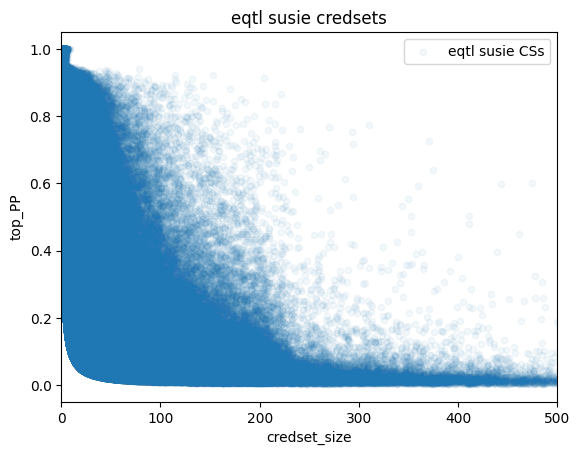

In [ ]:
# Credible_set. Please use Daniels’ notebook as a reference. For each subfolder:
# eqtl catalog susie:
eqtlcat_susie_path=f"{release_path}/{release_ver}/credible_set/eqtl_catalog_susie"
# Number of CSs.
eqtlcat_susie=session.spark.read.parquet(eqtlcat_susie_path, recursiveFileLookup=True)
print("Number of unique eqtl catalog susie CSs: ", eqtlcat_susie.select("studyId", "region", "credibleSetIndex").distinct().count(), " in ", eqtlcat_susie.select("studyId").distinct().count(), " studies.")
# Number of unique studyids with at leas one CS.
print("Number of eqtl catalog studies with at least one CS: ", eqtlcat_susie.select("studyId").distinct().count())
# The descriptive summary of 99% CS size and histogram/density plot
eqtlcat_susie_fm=eqtlcat_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability")))
eqtlcat_susie_fm.select("credset_size", "top_PP").toPandas().plot.scatter(x="credset_size", y="top_PP", xlim=[0, 500], alpha=0.05, label="eqtl susie CSs", title="eqtl susie credsets")
# Number of CSs with at leas one SNP with PIP>0.9
print("Number of CS with top SNP PP > 0.9: ", eqtlcat_susie_fm.filter(f.col("top_PP") > 0.9).count())
# Optional: the scatter plot of number of CSs per stydyid vs study sample size

Number of unique gwas catalog sumstats CSs:  247782  in  9679  studies.


Number of CS with top SNP PP > 0.9:  77724


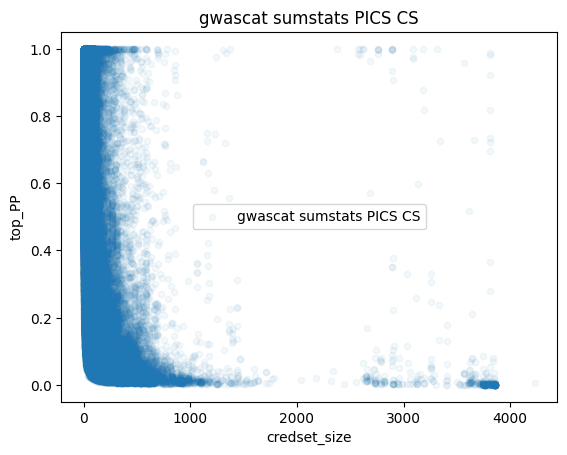

In [ ]:
# Credible_set. Please use Daniels’ notebook as a reference. For each subfolder:
# gwas catalog sumstats (PICs):
gwascat_sumstats_path=f"{release_path}/{release_ver}/credible_set/gwas_catalog_summary_statistics"
# Number of CSs.
gwascat_sumstats=session.spark.read.parquet(gwascat_sumstats_path, recursiveFileLookup=True)
#gwascat_sumstats.printSchema()
print("Number of unique gwas catalog sumstats CSs: ", gwascat_sumstats.select("studyLocusId").distinct().count(), " in ", gwascat_sumstats.select("studyId").distinct().count(), " studies.")
gwascat_sumstats_fm=gwascat_sumstats.select("studyId", "studyLocusId", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability")))
gwascat_sumstats_fm.select("credset_size", "top_PP").toPandas().plot.scatter(x="credset_size", y="top_PP", alpha=0.05, label="gwascat sumstats PICS CS", title="gwascat sumstats PICS CS")
print("Number of CS with top SNP PP > 0.9: ", gwascat_sumstats_fm.filter(f.col("top_PP") > 0.9).count())

Number of unique gwas catalog curated CSs:  531198  in  35662  studies.


Number of CS with top SNP PP > 0.9:  91998


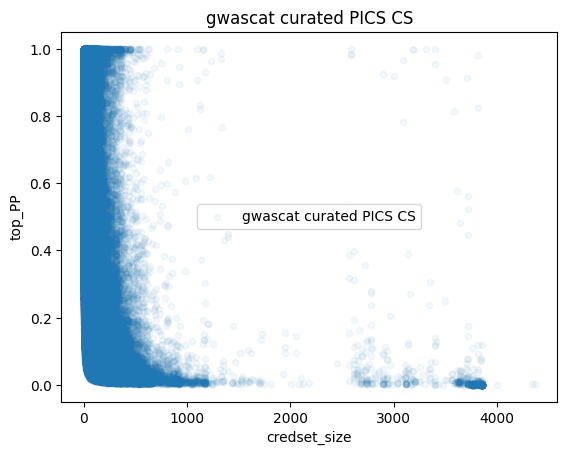

In [ ]:
# gwas catalog curated (PICs):
gwascat_sumstats_path=f"{release_path}/{release_ver}/credible_set/gwas_catalog_curated"
# Number of CSs.
gwascat_sumstats=session.spark.read.parquet(gwascat_sumstats_path, recursiveFileLookup=True)
#gwascat_sumstats.printSchema()
print("Number of unique gwas catalog curated CSs: ", gwascat_sumstats.select("studyLocusId").distinct().count(), " in ", gwascat_sumstats.select("studyId").distinct().count(), " studies.")
# keep only credible sets snps
gwascat_sumstats_fm=gwascat_sumstats.select("studyId", "studyLocusId", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability")))
gwascat_sumstats_fm.select("credset_size", "top_PP").toPandas().plot.scatter(x="credset_size", y="top_PP", alpha=0.05, label="gwascat curated PICS CS", title="gwascat curated PICS CS")
print("Number of CS with top SNP PP > 0.9: ", gwascat_sumstats_fm.filter(f.col("top_PP") > 0.9).count())

# sum pp within studylocusids and check if goes over 1, compare credset/locus size, does it contain non-credset snps

##### 6. Analyze colocalization data:
   - Count the total number of colocalizations and the number with clpp > 0.8.
   - Calculate the average number of overlaps per credible set.

In [ ]:
coloc_path=f"{release_path}/{release_ver}/colocalisation"
coloc=session.spark.read.parquet(coloc_path, recursiveFileLookup=True)

print("Number of colocalisations: ", coloc.count(), " , of which, ", coloc.filter(f.col("clpp") > 0.8).count(), " > 0.8 clpp (", round((coloc.filter(f.col("clpp") > 0.8).count()/coloc.count()), 3), "%)")
print("Average number of overlaps per CS: ", coloc.groupBy("leftStudyLocusId").count().agg(f.avg("count")).show())



Number of colocalisations:  46728996  , of which,  4031765  > 0.8 clpp ( 0.086 %)


+-----------------+
|       avg(count)|
+-----------------+
|90.78597906418297|
+-----------------+

Average number of overlaps per CS:  None


##### 7. Analyze locus-to-gene (L2G) predictions:
   - Histogram of l2g score distribution.
   - Number of CS with at least one gene with L2G>=0.5
   - Number of CS with more than one gene with L2G>=0.5

There are 8591772  locus to gene predictions for 607372  unique studyloci


Where  357875  studyloci contains at least one gene with score > 0.5


Of these,  122485  studyloci contains more than one gene with score > 0.5, ( 1.4000000000000001 %)


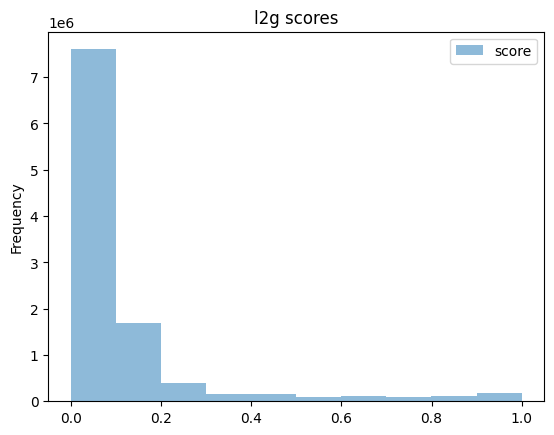

24/03/16 08:59:11 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 838985 ms exceeds timeout 120000 ms
24/03/16 08:59:11 WARN SparkContext: Killing executors is not supported by current scheduler.
24/03/16 08:59:11 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

In [ ]:
l2g_path=f"{release_path}/{release_ver}/locus_to_gene_predictions"
l2g=session.spark.read.parquet(l2g_path, recursiveFileLookup=True)
l2g.select("score").toPandas().plot.hist(bins=10, alpha=0.5, title="l2g scores")
print("There are", l2g.select("studyLocusId", "geneId").distinct().count(), " locus to gene predictions for", l2g.select("studyLocusId").distinct().count(), " unique studyloci")
print("Where ", l2g.filter(f.col("score") > 0.5).select("studyLocusId").distinct().count(), " studyloci contains at least one gene with score > 0.5")
print("Of these, ", l2g.filter(f.col("score") > 0.5).groupBy("studyLocusId").count().filter(f.col("count") > 1).count(), " studyloci contains more than one gene with score > 0.5, (", round((l2g.filter(f.col("score") > 0.5).groupBy("studyLocusId").count().filter(f.col("count") > 1).count()/l2g.select("studyLocusId", "geneId").distinct().count()), 3)*100, "%)")

# potentially duplicated studyId with finngen pics and susie

##### 7. Analyze locus-to-gene (L2G) predictions:
   - Consider only the top gene assignments from l2g:

<Axes: title={'center': 'l2g scores (top gene assignment)'}, ylabel='Frequency'>

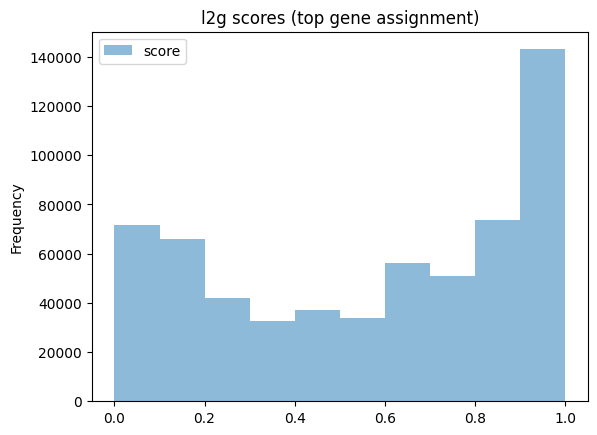

In [ ]:
from pyspark.sql import Window

window = Window.partitionBy(l2g['studyLocusId']).orderBy(l2g['score'].desc())
l2g = l2g.withColumn('rn', f.row_number().over(window))
l2g_max_scores = l2g.filter(l2g['rn'] == 1).drop('rn')
l2g_max_scores.select("score").toPandas().plot.hist(bins=10, alpha=0.5, title="l2g scores (top gene assignment)")

13131

In [ ]:
13131